# Ensemble Model
    - model : neural network
    - data : banksim
    - behavioural model : LOF model(novelty = True)

In [2]:
import os

In [3]:
computation = 'cloud'

In [4]:
if computation == 'local' :
    data_path = '../data/transaction_fraud/'
    global_model_path = '../models/globalmodel'
else :
    !pip install river
    !pip install imblearn
    !pip install xgboost
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud/'
    global_model_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
print(f'data files : {os.listdir(data_path)}')
print(f'searching global model  : {os.path.exists(global_model_path)}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
Mounted at /content/drive
data files : ['bs140513_032310.csv', 'bsNET140513_032310.csv']
searching global model  : True


In [5]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv(data_path + os.listdir(data_path)[0])
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [7]:
file = open(global_model_path , 'rb')
global_model = pickle.load(file)
print(f'input_features : {global_model.input_features} \n')
print(f'categorical_features : {global_model.categorical_features} \n')
print(f'data_preprocessing_info : {global_model.data_preprocessing_info} \n')
print(f'label_encoders : {global_model.label_encoders} \n')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:31] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


input_features : Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object') 

categorical_features : ['age', 'gender', 'category'] 

data_preprocessing_info : {'step': 'time from first transaction (int)(counter)', 'customer': 'frequency encoded account', 'age': 'label encoded (label encoder stored : le.transform(X[col])', 'gender': 'label encoded (label encoder stored : le.transform(X[col])', 'merchant': 'frequency encoded merchant account', 'category': 'label encoded (label encoder stored : le.transform(X[col])', 'amount': ''} 

label_encoders : {'age': LabelEncoder(), 'gender': LabelEncoder(), 'category': LabelEncoder()} 



In [8]:
#making a database like data structure to store the LOFs for individual customers
lof_database = {}

## Data Preprocessing

In [9]:
# removing quotations from the datasets
for c in df.columns :
    if df[c].dtype==object :
        df[c] = df[c].replace("'","", regex = True)
df.head()

copy_df = df.copy()


#frequency encoding of the merchants and customer
for c in ['customer' , 'merchant'] :
    frequency = df[c].value_counts()
    df[c] = df[c].apply(lambda x : frequency[x])

# label encoding the categorical features according to the global model's label encoder
for c in global_model.categorical_features :
    df[c] = global_model.label_encoders[f'{c}'].transform(df[c])

df.insert(loc = 1,
          column = 'account_id',
          value = copy_df['customer'])

df.insert(loc=5,
          column='merchant_id',
          value = copy_df['merchant'])
#label encod the merchant_id column
import sklearn.preprocessing
le = sklearn.preprocessing.LabelEncoder()
df['merchant_id'] = le.fit_transform(df['merchant_id'])

df.head()

df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)


df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
0,0,C1093826151,167,4,2,30,205426,12,4.55,0
1,0,C352968107,169,2,2,30,205426,12,39.68,0
2,0,C2054744914,65,4,1,18,299693,12,26.89,0
3,0,C1760612790,171,3,2,30,205426,12,17.25,0
4,0,C757503768,145,5,2,30,205426,12,35.72,0


## Test for category localization

/tmp/ipython-input-8-1318138406.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


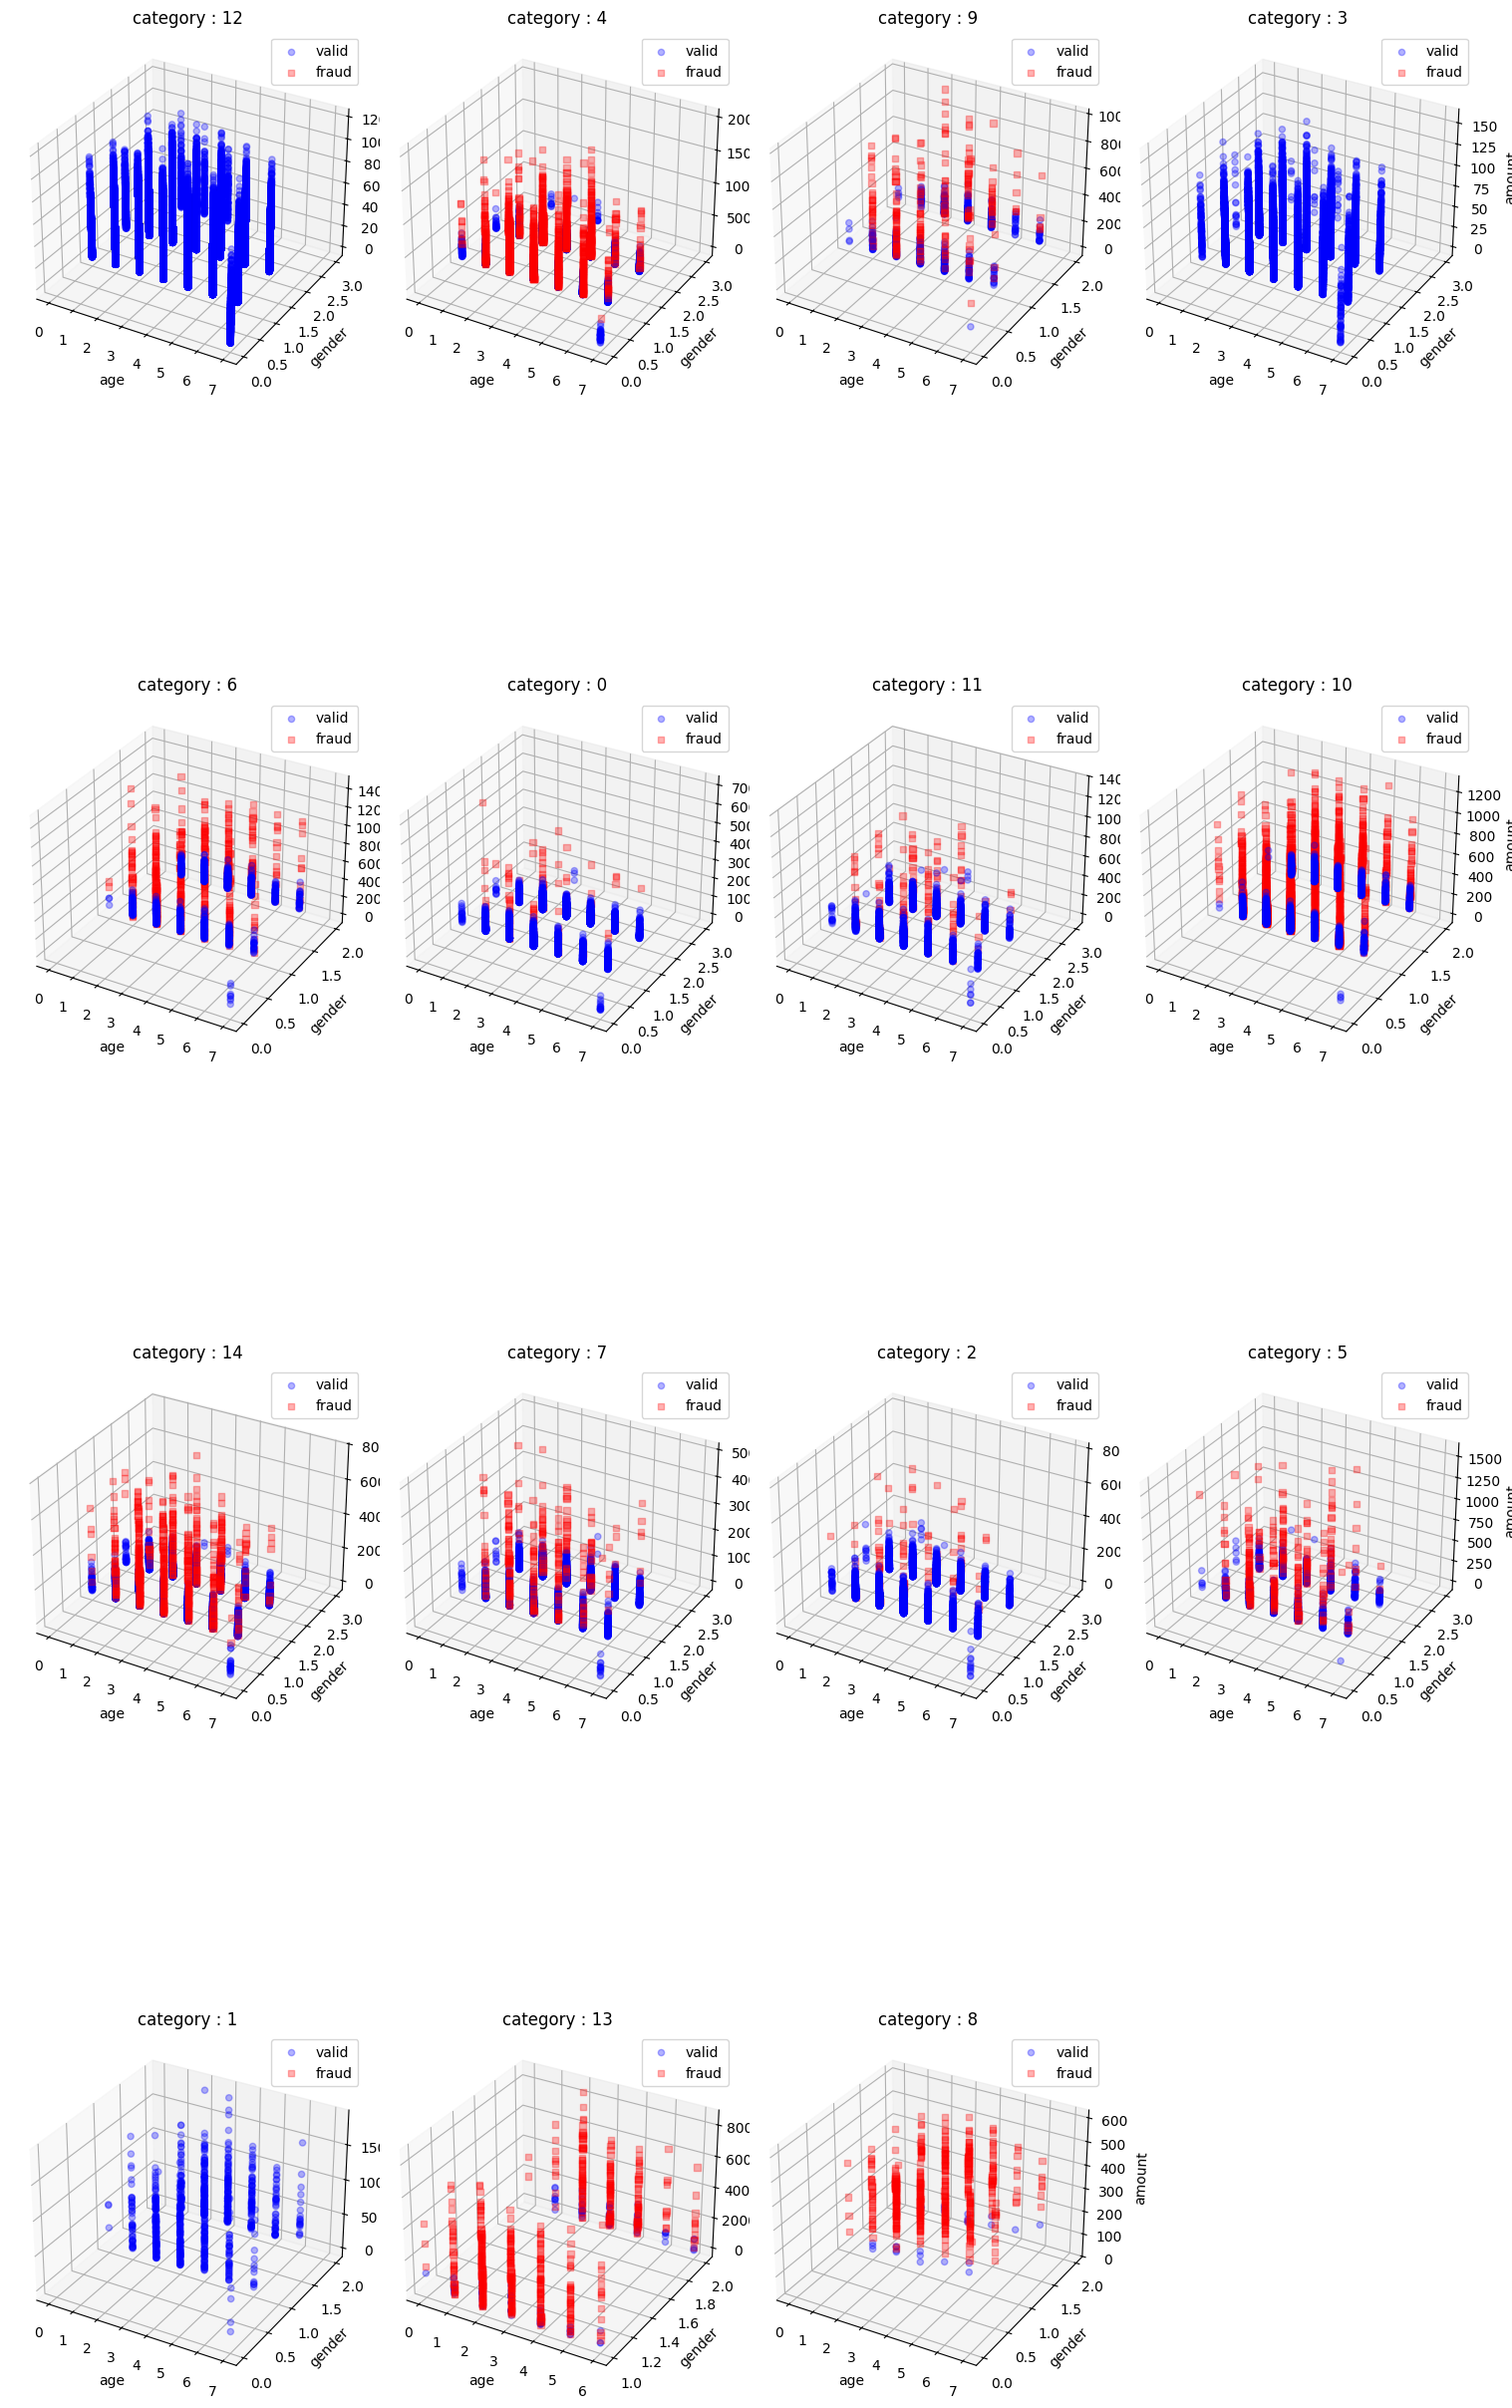

In [ ]:
#   fig = plt.figure(figsize=(7, 6))
#   ax = fig.add_subplot(111, projection='3d')
#   ax.scatter(df['age'][df['category']==category][df['fraud']==0],df['gender'][df['category']==category][df['fraud']==0],df['amount'][df['category']==category][df['fraud']==0], marker='o',color='b',alpha=0.3)
#   ax.scatter(df['age'][df['category']==category][df['fraud']==1],df['gender'][df['category']==category][df['fraud']==1],df['amount'][df['category']==category][df['fraud']==1], marker='s',color='r',alpha=0.3)
#   ax.set_xlabel('age')
#   ax.set_ylabel('gender')
#   ax.set_zlabel('amount')
#   ax.set_title(f'category : {category}')
#   plt.legend(['valid','fraud'])
#   plt.show()

num_categories = len(df['category'].unique())
n_cols = 4
n_rows = (num_categories + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i, category in enumerate(df['category'].unique()):
    ax = axes[i]
    ax.scatter(df['age'][df['category']==category][df['fraud']==0],df['gender'][df['category']==category][df['fraud']==0],df['amount'][df['category']==category][df['fraud']==0], marker='o',color='b',alpha=0.3)
    ax.scatter(df['age'][df['category']==category][df['fraud']==1],df['gender'][df['category']==category][df['fraud']==1],df['amount'][df['category']==category][df['fraud']==1], marker='s',color='r',alpha=0.3)
    ax.set_xlabel('age')
    ax.set_ylabel('gender')
    ax.set_zlabel('amount')
    ax.set_title(f'category : {category}')
    ax.legend(['valid','fraud'])

for j in range(num_categories, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Therefore we cannot localize onthe basis of category

## Test for account localization

In [ ]:
# accounts = df['account_id'].unique()
# for a in accounts :
#   data = df[df['account_id']==a]
#   if not data['fraud'].any() :
#     continue
#   fig, ax = plt.subplots()
#   fig.set_size_inches(3, 2)
#   ax.scatter(data['category'][data['fraud']==0],data['amount'][data['fraud']==0],marker='o',color='b',alpha=0.3)
#   ax.scatter(data['category'][data['fraud']==1],data['amount'][data['fraud']==1],marker='s',color='r',alpha=1)
#   ax.set_xlabel('category')
#   ax.set_ylabel('amount')
#   ax.set_title(f'account_id : {a}')
#   plt.legend(['valid','fraud'])
#   plt.show()

accounts = df['account_id'].unique()
num_accounts_with_fraud = sum(1 for a in accounts if df[df['account_id']==a]['fraud'].any())
n_cols = 5
n_rows = (num_accounts_with_fraud + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))
axes = axes.flatten()

plot_index = 0
for a in accounts:
    data = df[df['account_id']==a]
    if not data['fraud'].any():
        continue

    ax = axes[plot_index]
    ax.scatter(data['category'][data['fraud']==0],data['amount'][data['fraud']==0],marker='o',color='b',alpha=0.3)
    ax.scatter(data['category'][data['fraud']==1],data['amount'][data['fraud']==1],marker='s',color='r',alpha=1)
    ax.set_xlabel('category')
    ax.set_ylabel('amount')
    ax.set_title(f'account_id : {a}')
    ax.legend(['valid','fraud'])
    plot_index += 1

# Hide any unused subplots
for j in range(plot_index, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

So, account localization may be possible

## Splitting dataset

In [ ]:
df['account_id'].nunique()

4112

In [ ]:
total_sample = df.shape[0]
feed_index = (int)(total_sample * 0.25)
train_index = (int) (feed_index + (total_sample * 0.6))
test_index = total_sample
print(f'feed_index : {feed_index}')
print(f'train_index : {train_index}')
print(f'test_index : {test_index}')

feed_index : 148660
train_index : 505445
test_index : 594643


In [ ]:
# split the dataset accordingly
feed_df = df.iloc[:feed_index , :]
train_df = df.iloc[feed_index + 1 : train_index , :]
test_df = df.iloc[train_index + 1 : ,:]
print(f'feed_df length: {feed_df.shape[0]}')
print(f'train_df length: {train_df.shape[0]}')
print(f'test_df length: {test_df.shape[0]}')

feed_df length: 148660
train_df length: 356784
test_df length: 89197


In [ ]:
feed_df['account_id'].nunique()

4077

## Feeding Data
 - Making the lof models

In [ ]:
# make the LOF models for all the customer
from river import anomaly
accounts = df['account_id'].unique()
for a in accounts :
    lof_database[f'{a}'] = anomaly.LocalOutlierFactor(n_neighbors = 5)
print('Created lof models for all customer (ONE TIME PROCESS)')


Created lof models for all customer (ONE TIME PROCESS)


In [ ]:
feed_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
0,0,C1093826151,167,4,2,30,205426,12,4.55,0
1,0,C352968107,169,2,2,30,205426,12,39.68,0
2,0,C2054744914,65,4,1,18,299693,12,26.89,0
3,0,C1760612790,171,3,2,30,205426,12,17.25,0
4,0,C757503768,145,5,2,30,205426,12,35.72,0


In [ ]:
# feeding data
copy_feed_df = feed_df.drop(['step','customer','age','gender','merchant'],axis = 1)
for i in range(feed_df.shape[0]):
    data = copy_feed_df.iloc[i]
    account_id = data['account_id']
    is_fraud = data['fraud']
    if is_fraud == 1 :
        continue;
    data = data.drop(['account_id','fraud'])
    data = data.to_dict()
    lof_database[f'{account_id}'].learn_one(data)
print('fed data to all the lofs')

fed data to all the lofs


In [ ]:
lof_info = {
    'input_features' : ['merchant_id','category', 'amount'],
    'feature_details' : {
        'merchant_id' : 'label encoded merchant id',
        'category' : 'label encoded category features(from global model',
        'amount' : 'transaction value',
    }
}
lof_database['info'] = lof_info

## Create Ensemble data
 - output from global model
 - output from lof model

In [ ]:
ensemble_df = pd.DataFrame()

In [ ]:
train_df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
148661,52,C1389311354,173,5,2,18,299693,12,7.58,0
148662,52,C1035666255,170,2,2,11,2624,2,25.41,0
148663,52,C529952024,164,2,2,18,299693,12,35.32,0
148664,52,C1272188168,171,5,1,30,205426,12,2.55,0
148665,52,C1769359992,167,3,1,30,205426,12,24.31,0


- we need to create data for global transaction model
- we need to create data for LOF model

### Data from global model

In [ ]:
global_model

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=16,
                                                       n_estimators=389,
                                                       random_state=16))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='au...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=16, ...))

In [ ]:
global_model.input_features

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object')

In [ ]:
global_model_df = train_df.drop(['account_id' ,'merchant_id', 'fraud'],axis=1)
global_model_df.head()

,step,customer,age,gender,merchant,category,amount
148661,52,173,5,2,299693,12,7.58
148662,52,170,2,2,2624,2,25.41
148663,52,164,2,2,299693,12,35.32
148664,52,171,5,1,205426,12,2.55
148665,52,167,3,1,205426,12,24.31


In [ ]:
global_output = global_model.predict_proba(global_model_df)
print(global_output)

[[9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 ...
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]]


In [ ]:
ensemble_df[['g_output_valid' , 'g_output_fraud']] = global_output
ensemble_df.head()

,g_output_valid,g_output_fraud
0,0.999999,0.000001
1,0.999999,0.000001
2,0.999999,0.000001
3,0.999999,0.000001
4,0.999999,0.000001


In [ ]:
ensemble_df = ensemble_df.drop('g_output_valid',axis =1)
ensemble_df.head()

,g_output_fraud
0,0.000001
1,0.000001
2,0.000001
3,0.000001
4,0.000001


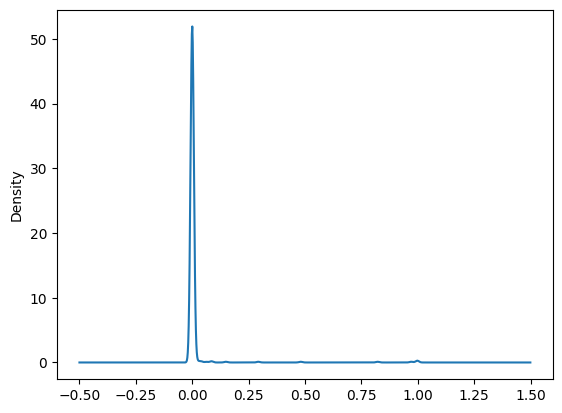

In [ ]:
ensemble_df['g_output_fraud'].plot.density()
plt.show()

### Data from LOF models

In [ ]:
lof_database['info']['input_features']

['merchant_id', 'category', 'amount']

In [ ]:
from river import anomaly
lof_scores = []
for i in range(train_df.shape[0]) :
    account_id = train_df.iloc[i]['account_id']
    is_fraud = train_df.iloc[i]['fraud']
    if f'{account_id}' not in lof_database :
        lof_database[f'{account_id}'] = anomaly.LocalOutlierFactor(n_neighbors = 10)
    data = train_df.iloc[i].drop(['step','account_id','customer','age','gender','merchant','fraud'])
    data = data.to_dict()
    lof_scores.append(lof_database[f'{account_id}'].score_one(data))
    if is_fraud == 0 :
        lof_database[f'{account_id}'].learn_one(data)

print(lof_scores[:5])

[0.9873859064405992, 17.553543430285032, 1.156614582118338, 1.0192333331099734, 1.1057860636882606]


In [ ]:
print(len(lof_scores))
print(ensemble_df.shape[0])

356784
356784


In [ ]:
num_cols = 1
lof_scores_2d = [lof_scores[i:i + num_cols] for i in range(0, len(lof_scores), num_cols)]
print(len(lof_scores_2d))

356784


In [ ]:
ensemble_df[['lof_scores']] = lof_scores_2d
ensemble_df.head()

,g_output_fraud,lof_scores
0,0.000001,0.987386
1,0.000001,17.553543
2,0.000001,1.156615
3,0.000001,1.019233
4,0.000001,1.105786


In [ ]:
fraud_array = train_df['fraud'].to_numpy()
fraud_array = fraud_array.reshape(fraud_array.shape[0],1)
print(fraud_array.shape)

(356784, 1)


In [ ]:
ensemble_df['fraud'] = fraud_array
ensemble_df.head()

,g_output_fraud,lof_scores,fraud
0,0.000001,0.987386,0
1,0.000001,17.553543,0
2,0.000001,1.156615,0
3,0.000001,1.019233,0
4,0.000001,1.105786,0


### saving ensemble data

In [ ]:
save_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)
ensemble_df.to_csv(save_data_path + 'ensemble_train_data.csv',index=False)

 now the data is ready .

## Training Ensemble

In [ ]:
def evaluate_model(model,
                   model_name,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test) :
    model.fit(X_train, Y_train)
    y_cap = model.predict(X_test)
    print(f'Evaluation_for {model_name}: ')
    print(classification_report(Y_test, y_cap))
    conf_mat = confusion_matrix(Y_test, y_cap)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('y_cap')
    plt.ylabel('y_test')
    plt.show()

    #ROC curve and the area under curve
    y_score = model.predict_proba(X_test)[:,1]
    false_pos_rate , true_pos_rate, thr = roc_curve(Y_test, y_score)
    roc_auc = auc(false_pos_rate , true_pos_rate)

    plt.figure(figsize = (7,5))
    plt.plot(false_pos_rate, true_pos_rate, label = f'ROC Curve, area = {roc_auc:.3f}')
    plt.plot([0,1] , [0,1] , linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Precision-Recall curve Nad AUC
    precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
ensemble_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/ensemble_train_data.csv'
ensemble_df = pd.read_csv(ensemble_data_path)
ensemble_df.head()

,g_output_fraud,lof_scores,fraud
0,0.000001,0.987386,0
1,0.000001,17.553543,0
2,0.000001,1.156615,0
3,0.000001,1.019233,0
4,0.000001,1.105786,0


### EDA

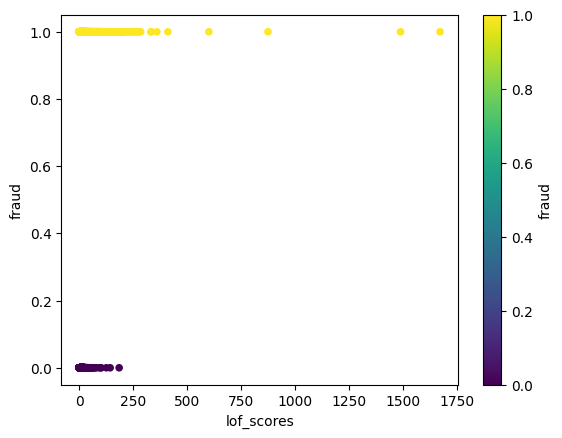

In [ ]:
ensemble_df.plot.scatter(x = 'lof_scores',y = 'fraud',c = 'fraud',colormap = 'viridis')
plt.show()

from the above graph it is very clear that novelty detection is working nicely , the outlier data points which are the frauds in this case are nicely being scored.

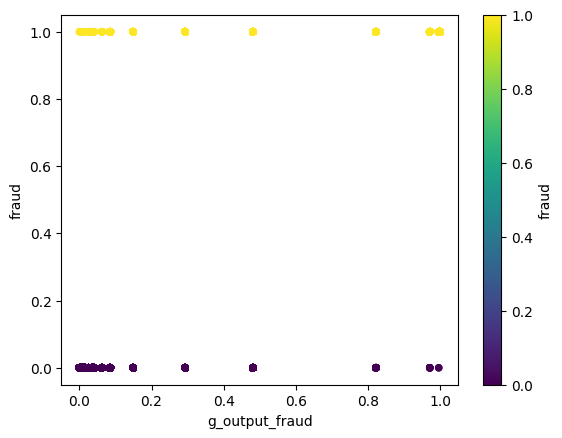

In [ ]:
ensemble_df.plot.scatter(x = 'g_output_fraud',y = 'fraud',c = 'fraud',colormap = 'viridis')
plt.show()

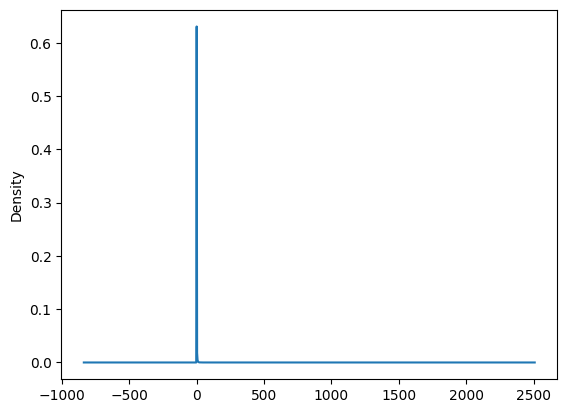

In [ ]:
ensemble_df['lof_scores'].plot.density()
plt.show()

now we will seee the correlation matrix for similarities in the features

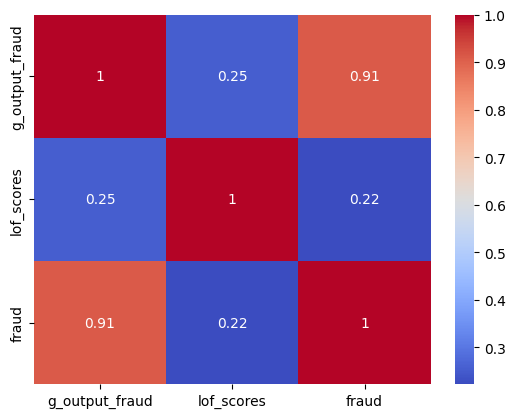

In [ ]:
corr_matrix = ensemble_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

now. we will choose the model that perfectly does the jod, but before that we need to split the data

In [ ]:
X = ensemble_df.drop('fraud',axis=1)
Y = ensemble_df['fraud']
X_train,X_test,y_train,y_test = train_test_split(X, Y,
                                                  test_size=0.2,
                                                  random_state=16)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(285427, 2)
(285427,)
(71357, 2)
(71357,)


### Logistic regression

Evaluation_for Logistic Regression: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70526
           1       0.91      0.86      0.89       831

    accuracy                           1.00     71357
   macro avg       0.96      0.93      0.94     71357
weighted avg       1.00      1.00      1.00     71357



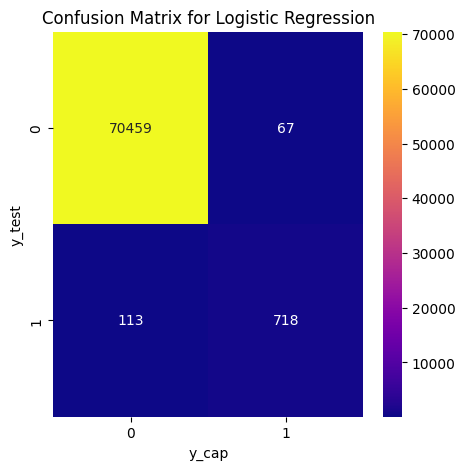

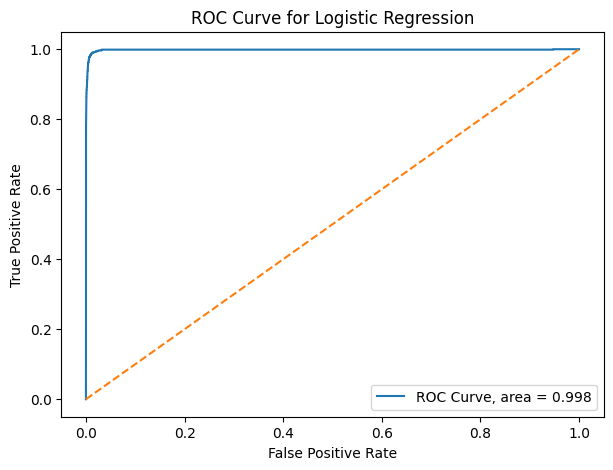

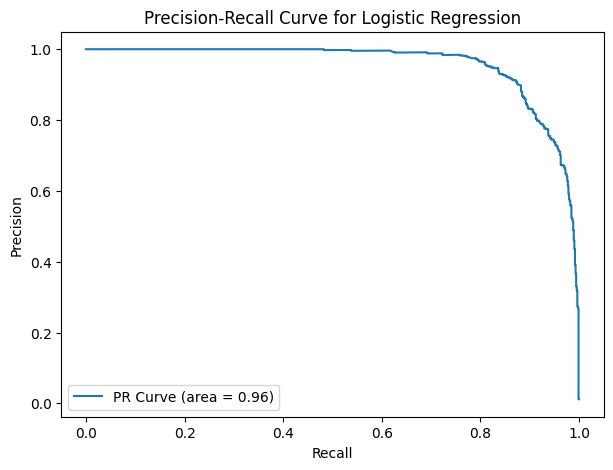

In [ ]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(),
               'Logistic Regression',
               X_train,
               y_train,
               X_test,
               y_test)

### Random Forest

Evaluation_for Random Forest: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70526
           1       0.83      0.84      0.84       831

    accuracy                           1.00     71357
   macro avg       0.92      0.92      0.92     71357
weighted avg       1.00      1.00      1.00     71357



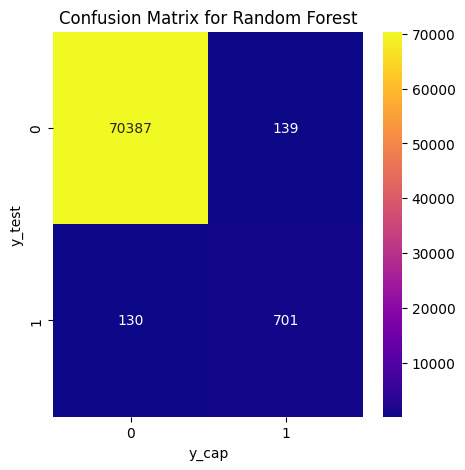

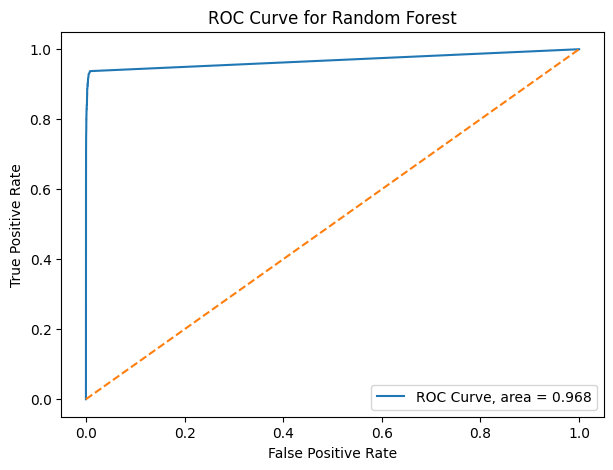

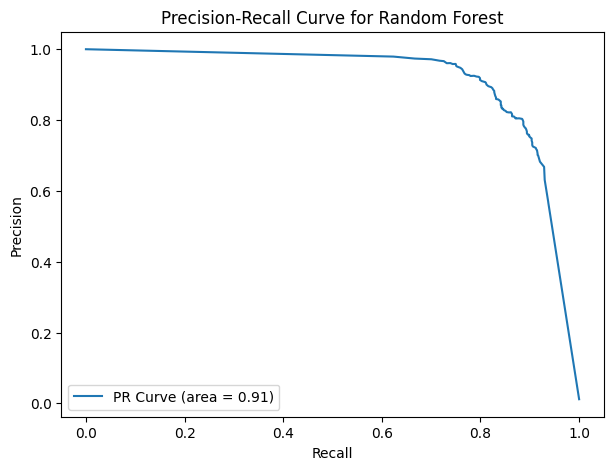

In [ ]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(),
               'Random Forest',
               X_train,
               y_train,
               X_test,
               y_test)

### XGBoost

Evaluation_for XGBoost: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70526
           1       0.91      0.86      0.88       831

    accuracy                           1.00     71357
   macro avg       0.95      0.93      0.94     71357
weighted avg       1.00      1.00      1.00     71357



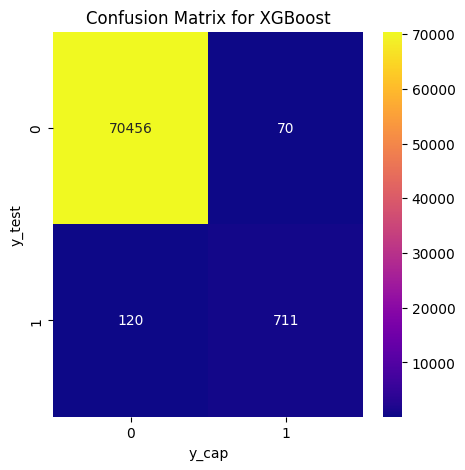

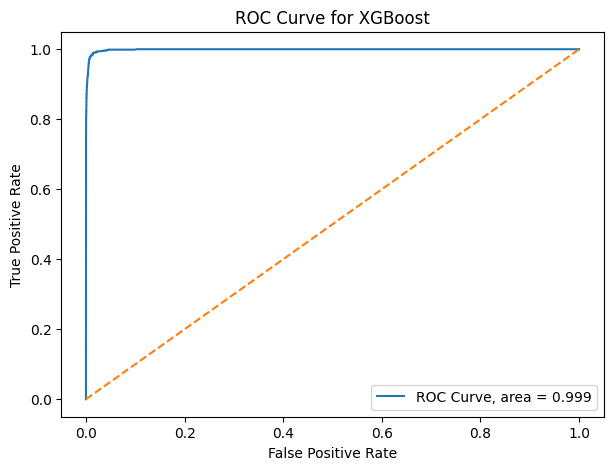

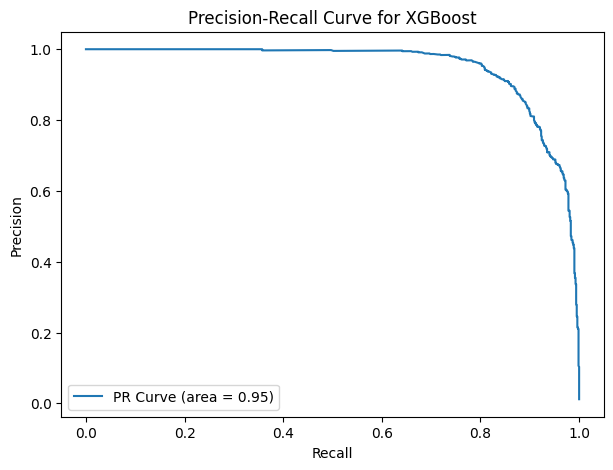

In [ ]:
from xgboost import XGBClassifier
evaluate_model(XGBClassifier(),
               'XGBoost',
               X_train,
               y_train,
               X_test,
               y_test)

### Balanced Random Forest

Evaluation_for Balanced Random Forest: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70526
           1       0.50      0.98      0.67       831

    accuracy                           0.99     71357
   macro avg       0.75      0.99      0.83     71357
weighted avg       0.99      0.99      0.99     71357



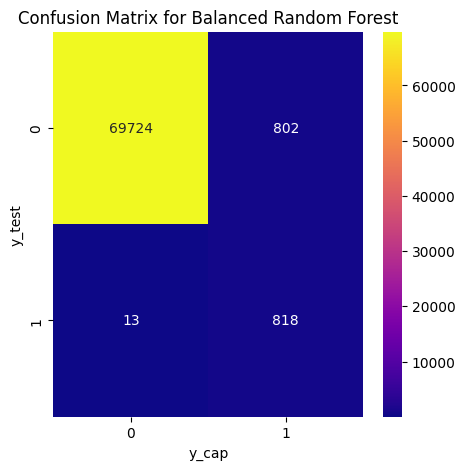

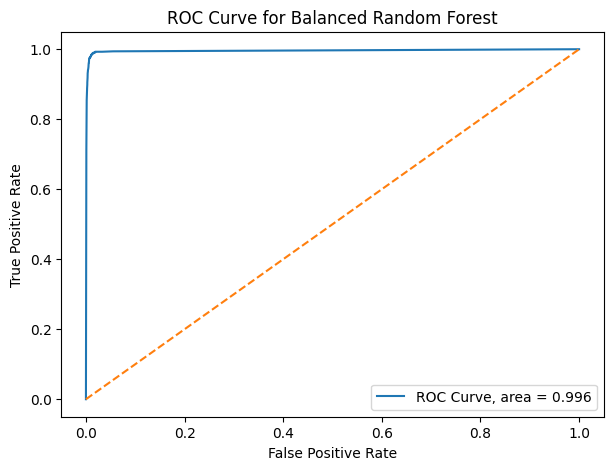

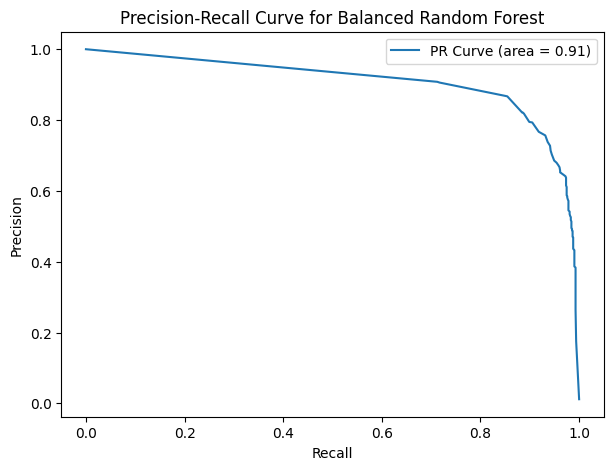

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
evaluate_model(BalancedRandomForestClassifier(),
               'Balanced Random Forest',
               X_train,
               y_train,
               X_test,
               y_test)

### neural Network

Evaluation_for Neural Network: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70526
           1       0.91      0.87      0.89       831

    accuracy                           1.00     71357
   macro avg       0.95      0.93      0.94     71357
weighted avg       1.00      1.00      1.00     71357



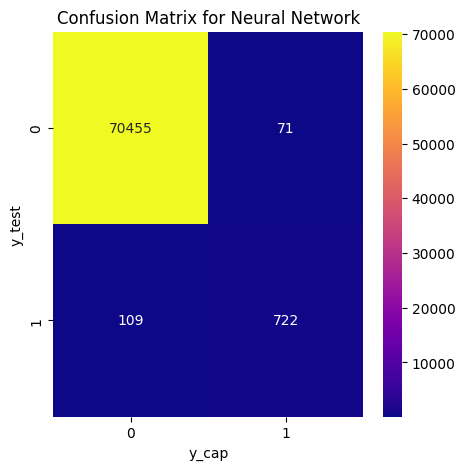

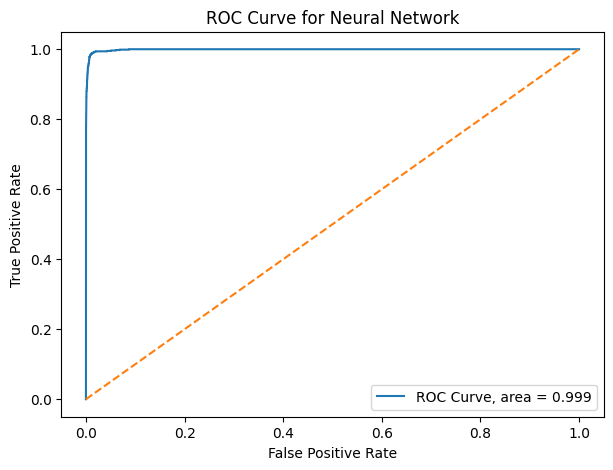

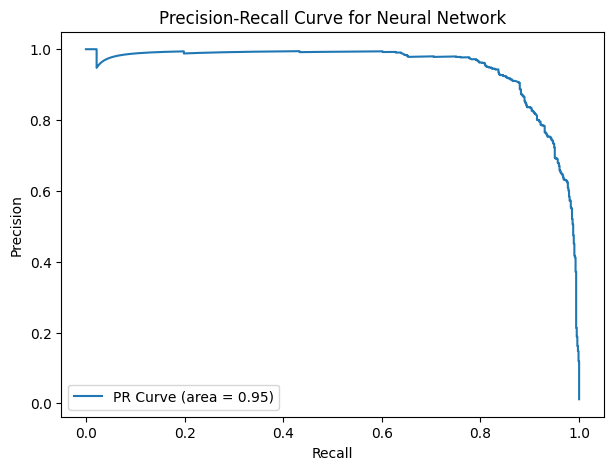

In [ ]:
from sklearn.neural_network import MLPClassifier
evaluate_model(MLPClassifier(),
               'Neural Network',
               X_train,
               y_train,
               X_test,
               y_test)

### AdaBoost Classifier

Evaluation_for AdaBoost Classifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70526
           1       0.90      0.87      0.89       831

    accuracy                           1.00     71357
   macro avg       0.95      0.94      0.94     71357
weighted avg       1.00      1.00      1.00     71357



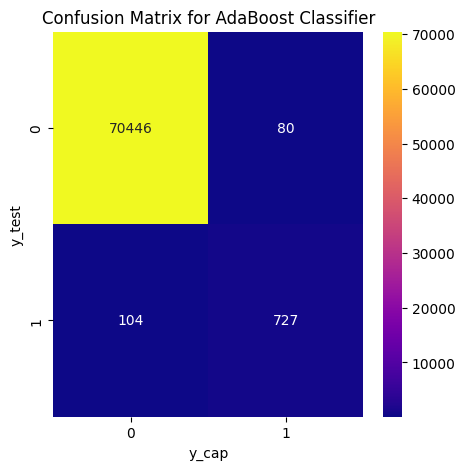

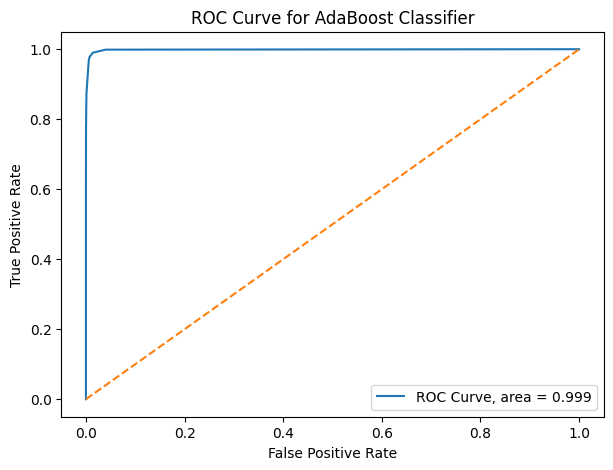

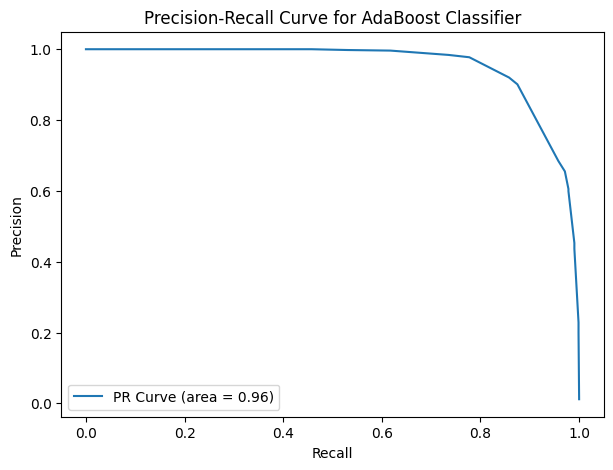

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
evaluate_model(AdaBoostClassifier(),
               'AdaBoost Classifier',
               X_train,
               y_train,
               X_test,
               y_test)

### saving ensemble model
the neural network performs best in this situation, we will use the neural network for the final ensemble.**bold text**

In [ ]:
ensemble_model = MLPClassifier()
ensemble_model.fit(X_train,y_train)

MLPClassifier()

In [ ]:
ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel'
file = open(ensemble_save_path , 'wb')
pickle.dump(ensemble_model, file)
print('saved ensemble model')

saved ensemble model


## Testing



In [10]:
ensemble_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/ensemblemodel'
file = open(ensemble_save_path , 'rb')
ensemble_model = pickle.load(file)
print('loaded ensemble model')
ensemble_model

loaded ensemble model


MLPClassifier()

In [11]:
global_model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
file = open(global_model_save_path , 'rb')
global_model = pickle.load(file)
print('loaded global model')
global_model

loaded global model


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=14,
                                                       min_samples_split=16,
                                                       n_estimators=389,
                                                       random_state=16))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='au...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=400, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=16, ...))

In [ ]:
#evaluate model on ensemble_data
y_cap = ensemble_model.predict(ensemble_df.drop('fraud',axis=1))
y_test = ensemble_df['fraud']
print(classification_report(y_test, y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    352650
           1       0.90      0.86      0.88      4134

    accuracy                           1.00    356784
   macro avg       0.95      0.93      0.94    356784
weighted avg       1.00      1.00      1.00    356784



In [12]:
df.head()

,step,account_id,customer,age,gender,merchant_id,merchant,category,amount,fraud
0,0,C1093826151,167,4,2,30,205426,12,4.55,0
1,0,C352968107,169,2,2,30,205426,12,39.68,0
2,0,C2054744914,65,4,1,18,299693,12,26.89,0
3,0,C1760612790,171,3,2,30,205426,12,17.25,0
4,0,C757503768,145,5,2,30,205426,12,35.72,0


In [13]:
global_model.input_features

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object')

In [14]:
ensemble_model.feature_names_in_

array(['g_output_fraud', 'lof_scores'], dtype=object)

In [15]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
global_pred = global_model.predict(df.drop(['account_id','merchant_id','fraud'],axis=1))
global_pred_proba = global_model.predict_proba(df.drop(['account_id','merchant_id','fraud'],axis=1))
print('prediction : \n',global_pred[:5])
print('prediction probabvility : \n',global_pred_proba[:5])

prediction : 
 [0 0 0 0 0]
prediction probabvility : 
 [[9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]
 [9.9999857e-01 1.4420659e-06]]


In [17]:
lof_database = {}
# make the LOF models for all the customer
from river import anomaly
accounts = df['account_id'].unique()
for a in accounts :
    lof_database[f'{a}'] = anomaly.LocalOutlierFactor(n_neighbors = 5)
    lof_database[f'{a}'].count = 0
print('Created lof models for all customer (ONE TIME PROCESS)')
lof_info = {
    'input_features' : ['merchant_id','category', 'amount'],
    'feature_details' : {
        'merchant_id' : 'label encoded merchant id',
        'category' : 'label encoded category features(from global model',
        'amount' : 'transaction value',
    }
}
lof_database['info'] = lof_info

Created lof models for all customer (ONE TIME PROCESS)


In [ ]:
y_cap = np.array([])
for i in range(df.shape[0]) :
  data = df.iloc[i]
  account_id = data['account_id']
  is_fraud = data['fraud']
  if f'{account_id}' not in lof_database :
    lof_database[f'{account_id}'] = anomaly.LocalOutlierFactor(n_neighbors = 5)
    lof_database[f'{account_id}'].count = 0

  g_prediction = global_pred[i]
  g_prediction_proba_fraud = global_pred_proba[i][1]


  data4lof = data.drop(['step','account_id','customer','age','gender','merchant','fraud'])
  data4lof = data4lof.to_dict()
  # print('global_pred',g_prediction)
  # print('global_pred_proba',g_prediction_proba_fraud)
  # print('data4lof',data4lof)

  if lof_database[f'{account_id}'].count >= 0 :
    lof_score = lof_database[f'{account_id}'].score_one(data4lof)
    data4ensemble = np.array([g_prediction_proba_fraud,lof_score]).reshape(1,-1)
    e_prediction = ensemble_model.predict(data4ensemble)
    # print(f'lof_score {lof_score}')
    # print('data4ensemble',data4ensemble)
    # print('prediction',e_prediction)
    y_cap = np.append(y_cap,e_prediction[0])
  else :
    y_cap = np.append(y_cap,global_pred[0])
  # print('\n')

  if is_fraud == 0 :
    lof_database[f'{account_id}'].learn_one(data4lof)
    lof_database[f'{account_id}'].count += 1


print('Pipeline run on all data : ')
print('output y_cap with shape : ', y_cap.shape)

Pipeline run on all data : 
output y_cap with shape :  (594643,)


In [ ]:
y_cap.reshape(y_cap.shape[0],1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y = df['fraud']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    587443
           1       0.90      0.86      0.88      7200

    accuracy                           1.00    594643
   macro avg       0.95      0.93      0.94    594643
weighted avg       1.00      1.00      1.00    594643



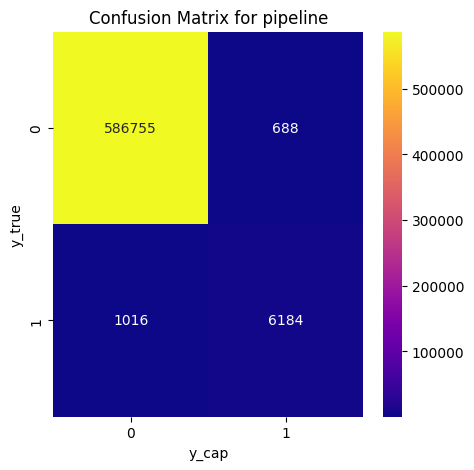

0.9288588557149848
0.89988358556461
0.8588888888888889


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score
print(classification_report(y, y_cap))
conf_mat = confusion_matrix(y, y_cap)
plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
plt.title(f'Confusion Matrix for pipeline')
plt.xlabel('y_cap')
plt.ylabel('y_true')
plt.show()
print(roc_auc_score(y, y_cap))
print(precision_score(y, y_cap))
print(recall_score(y, y_cap))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    587443
           1       0.97      0.77      0.86      7200

    accuracy                           1.00    594643
   macro avg       0.99      0.89      0.93    594643
weighted avg       1.00      1.00      1.00    594643



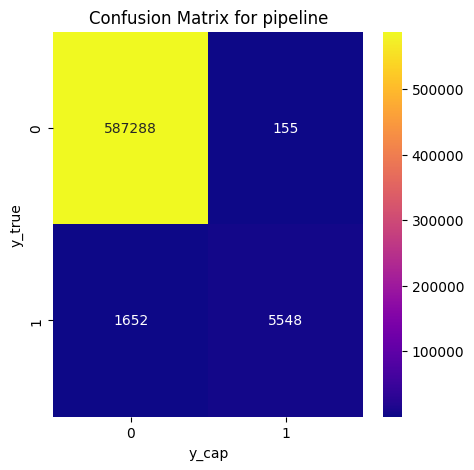

0.8851458500843676
0.9728213221111696
0.7705555555555555


In [ ]:
y_cap = global_pred
print(classification_report(y, y_cap))
conf_mat = confusion_matrix(y, y_cap)
plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
plt.title(f'Confusion Matrix for pipeline')
plt.xlabel('y_cap')
plt.ylabel('y_true')
plt.show()
print(roc_auc_score(y, y_cap))
print(precision_score(y, y_cap))
print(recall_score(y, y_cap))